In [1]:
import glob
import numpy as np
import warnings

from pandas import DataFrame, read_hdf
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

import nenequitia.models as MODELS
from nenequitia.models.baseline import BaselineModule
from nenequitia.datasets import DataFrameDataset, BaselineDataFrameDataset
from nenequitia.contrib import get_manuscripts_and_lang_kfolds

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

In [2]:
# Cleans the dataframe
lines = "texts.hdf5"
lines = read_hdf(lines)
# lines = lines[lines.manuscript == "SBB_PK_Hdschr25"]
lines["bin"] = ""
lines.loc[lines.CER < 10, "bin"] = "Good"
lines.loc[lines.CER.between(10, 25, inclusive="left"), "bin"] = "Acceptable"
lines.loc[lines.CER.between(25, 50, inclusive="left"), "bin"] = "Bad"
lines.loc[lines.CER >= 50, "bin"] = "Very bad"

In [180]:
lines["length"] = lines.transcription.apply(len)

In [205]:
lines[(lines.length == 50) & (lines.CER.between(11, 13))][["transcription", "CER"]]
lines[lines.transcription.str.contains("quãt tel")][["transcription", "CER"]].to_records()

rec.array([(181920, 'quãt tel ensant gist en tel liei. Dderice respont', 11.99999973),
           (244697, 'quãt tel enfant gist en tes lieu. Derite respont',  5.99999987),
           (308549, 'quãt tel enfant gist en tes lieu. Derite respont',  5.99999987),
           (342947, 'quãt tel enfant gist en tel lieu . Verite respont',  0.        ),
           (155502, 'quãt tel enfant gist en tel lieu. Uerite respont',  3.99999991),
           (203080, 'quãt tel enfant gist en tel lieu. Derite respont',  3.99999991),
           (287608, 'quãt tel eufaut gist en tes lieu. Derite respoint', 11.99999973)],
          dtype=[('index', '<i8'), ('transcription', 'O'), ('CER', '<f8')])

In [3]:
def get_class_scores(model):
    confmat = model.metric_confusion.confmat.cpu().numpy()

    current_model = {}
    # get_manuscripts_and_lang_kfolds
    for cls in range(confmat.shape[0]):
        precision = confmat[cls, cls] / confmat[:, cls].sum()
        recall = confmat[cls, cls] / confmat[cls, :].sum()
        # MCC = MostCommonConfusion
        # MCP = MostCommonPrediction
        # Support 
        keys = "Pre Rec MCC MCP Support".split()
        print_cls = "_".join(model.encoder.ys[cls].split())
        current_model.update({
            f"Score({print_cls})[{key}]": val
            for key, val in dict(zip(keys, (
                precision,
                recall,
                model.encoder.ys[confmat[cls, :].argmax()],
                model.encoder.ys[confmat[:, cls].argmax()],
                confmat[cls, :].sum()
            ))).items()
        })

    return current_model

In [4]:
batch_predictions = []
truthes = []
sentence_lengthes = []
modules = []
k_records = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for file in (*glob.glob("explogs-baseline/*/*/checkpoints/*"), *glob.glob("explogs/*/*/checkpoints/*")):
        results = []
        exp, module, k, *_ = file.split("/")
        print(k)
        _, _, dataset = get_manuscripts_and_lang_kfolds(lines, k=int(k),
                per_k=2,
                force_test=["SBB_PK_Hdschr25"])
        dataset = dataset[dataset.manuscript != "SBB_PK_Hdschr25"]
        dataset_class = DataFrameDataset
        if module.startswith("Baseline"):
            dataset_class = BaselineDataFrameDataset
            module_class = BaselineModule
        else:
            module_class = getattr(MODELS, module)
        model = module_class.load_from_checkpoint(file, training=True)
        model.eval()
        dataset = dataset_class(dataset, model.encoder)
        dl = DataLoader(dataset, collate_fn=model.encoder.collate_pred, batch_size=256, shuffle=False)
        
        t = Trainer(
            accelerator="gpu",
            devices=1,
            precision=16
        )
        #predictor = Trainer.predict(model, batch)
        batch_predictions.extend([
            pred
            for batch in t.predict(model=model, dataloaders=dl)
            for pred in batch
        ])
        truthes.extend([
            model.encoder.ys[dataset[element][1]]
            for element in range(len(dataset))
        ])
        sentence_lengthes.extend([
            len(dataset._transcriptions[element]) - 3
            for element in range(len(dataset))
        ])
        modules.extend([module]*len(dataset))
        k_records.extend([k]*len(dataset))

3


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

0


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

0


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

4


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

1


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

3


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

0


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

4


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

1


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

3


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

0


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

4


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

1


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

3


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

0


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

4


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

1


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [35]:
from pandas import cut
renamed_module = {
    "AttentionalModule": "Attention",
    "RnnModule": "BiLSTM" ,
    "TextCnnModule": "TextCNN",
    "Baseline": "Baseline"
}
results = DataFrame({
    "prediction": batch_predictions,
    "truth": truthes,
    "length": sentence_lengthes,
    "module": [renamed_module[module] for module in modules],
    "k": k_records
})
results["correct"] = results.truth == results.prediction
results['quantile_length'] = cut(
    results['length'],
    bins=list(range(15, results['length'].max(), 5)), 
    labels = list(range(15, results['length'].max(), 5))[:-1],
    include_lowest = True
)

pivot = results.pivot_table(
    index=["module", "k"],
    values=["correct"],
    columns=["truth", "quantile_length"],
    aggfunc=lambda x: np.round(x.tolist().count(True) / len(x)*100, 2)
)

In [36]:
list(range(15, results['length'].max(), 5))
results['quantile_length'].unique()

[35, 30, NaN, 20, 25, ..., 95, 90, 105, 100, 110]
Length: 21
Categories (20, int64): [15 < 20 < 25 < 30 ... 95 < 100 < 105 < 110]

In [40]:
leveled_df = []

for ((module, k), row) in pivot.iterrows():
    #print(row)
    break

COLORS = {
    "AttentionalModule": (255, 0, 0),
    "RnnModule": (255, 0, 0),
    "TextCnnModule": (255, 0, 0)
}
    
    
for row in pivot.reset_index(0).to_dict(orient='records'):
    module = row[('module', '', '')]
    for ((key, cls, length), score) in row.items():
        if key != "module":
            leveled_df.append({
                "Encoder": module,
                "Class": cls,
                "Length (NFD Character Count)": length,
                "Accuracy": score
            })
leveled = DataFrame(leveled_df)

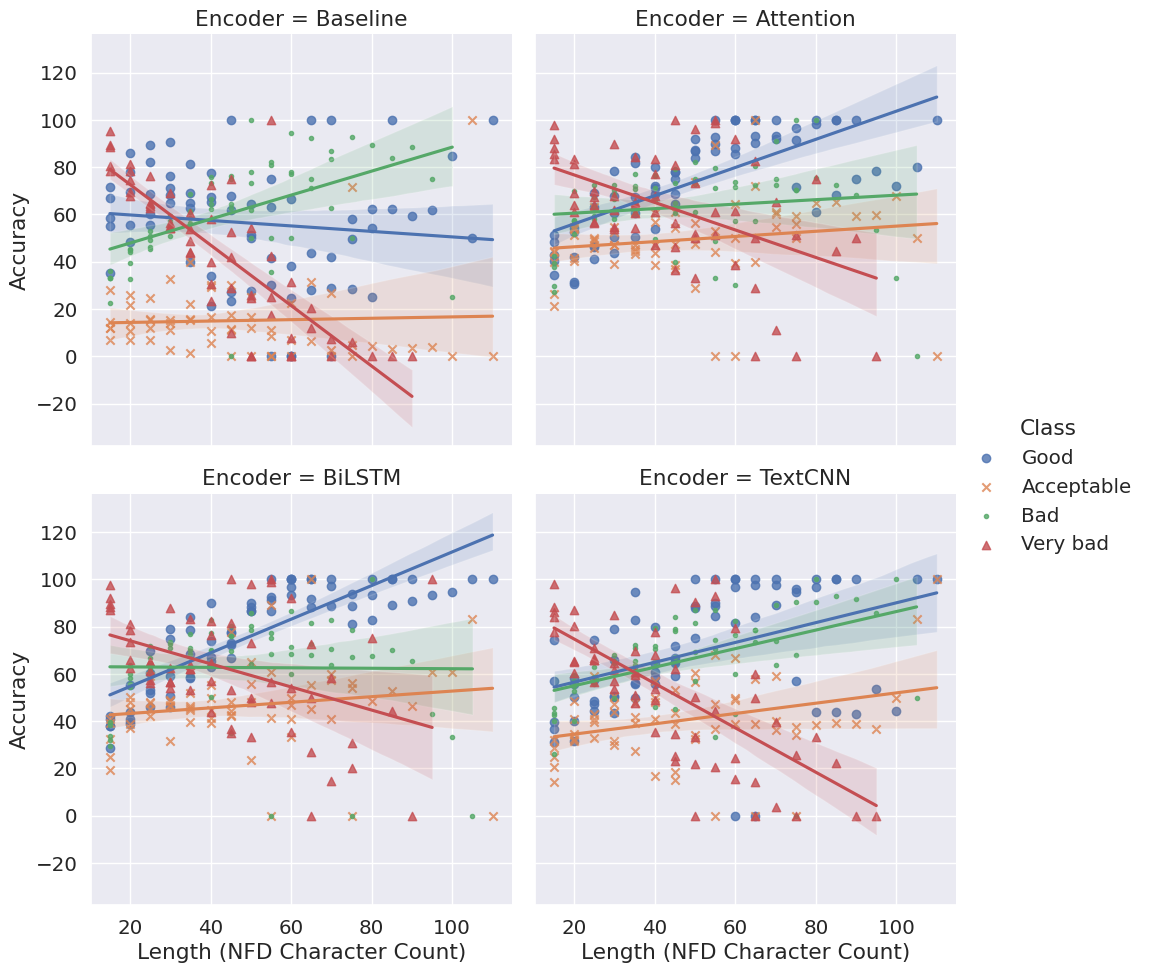

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g = sns.lmplot(
    data=leveled, x="Length (NFD Character Count)", y="Accuracy", col="Encoder", hue="Class",
    markers=["o", "x", ".", "^"], col_wrap=2,
    hue_order=["Good", "Acceptable", "Bad", "Very bad"],
    col_order=["Baseline", "Attention", "BiLSTM", "TextCNN"]
    #palette=sns.diverging_palette(150, 10, n=4)
)

plt.savefig('sizes.png', dpi=400)

In [148]:
filtered = results[results.correct != True]

new_df = []

for ((module, k), row) in filtered.pivot_table(
    index=["module", "k"],
    values="prediction",
    columns=["truth"],
    aggfunc=lambda x: (
        {cls: (val, np.round(val/len(x)*100, 2)) for cls, val in x.value_counts().to_dict().items()},
        len(x)
    )
).iterrows():
    for ((cls), score) in row.items():
        if not isinstance(score, tuple):
            continue
        (score, support) = score
        if support > 50:
            for confusion, (support, percent) in score.items():
                new_df.append({
                    "Encoder": module,
                    "Class": cls,
                    "Predicted": confusion,
                    #"Length (NFD Character Count)": length,
                    "% of Confusions": percent, 
                    "Support": support
            })
new_df = DataFrame(new_df)

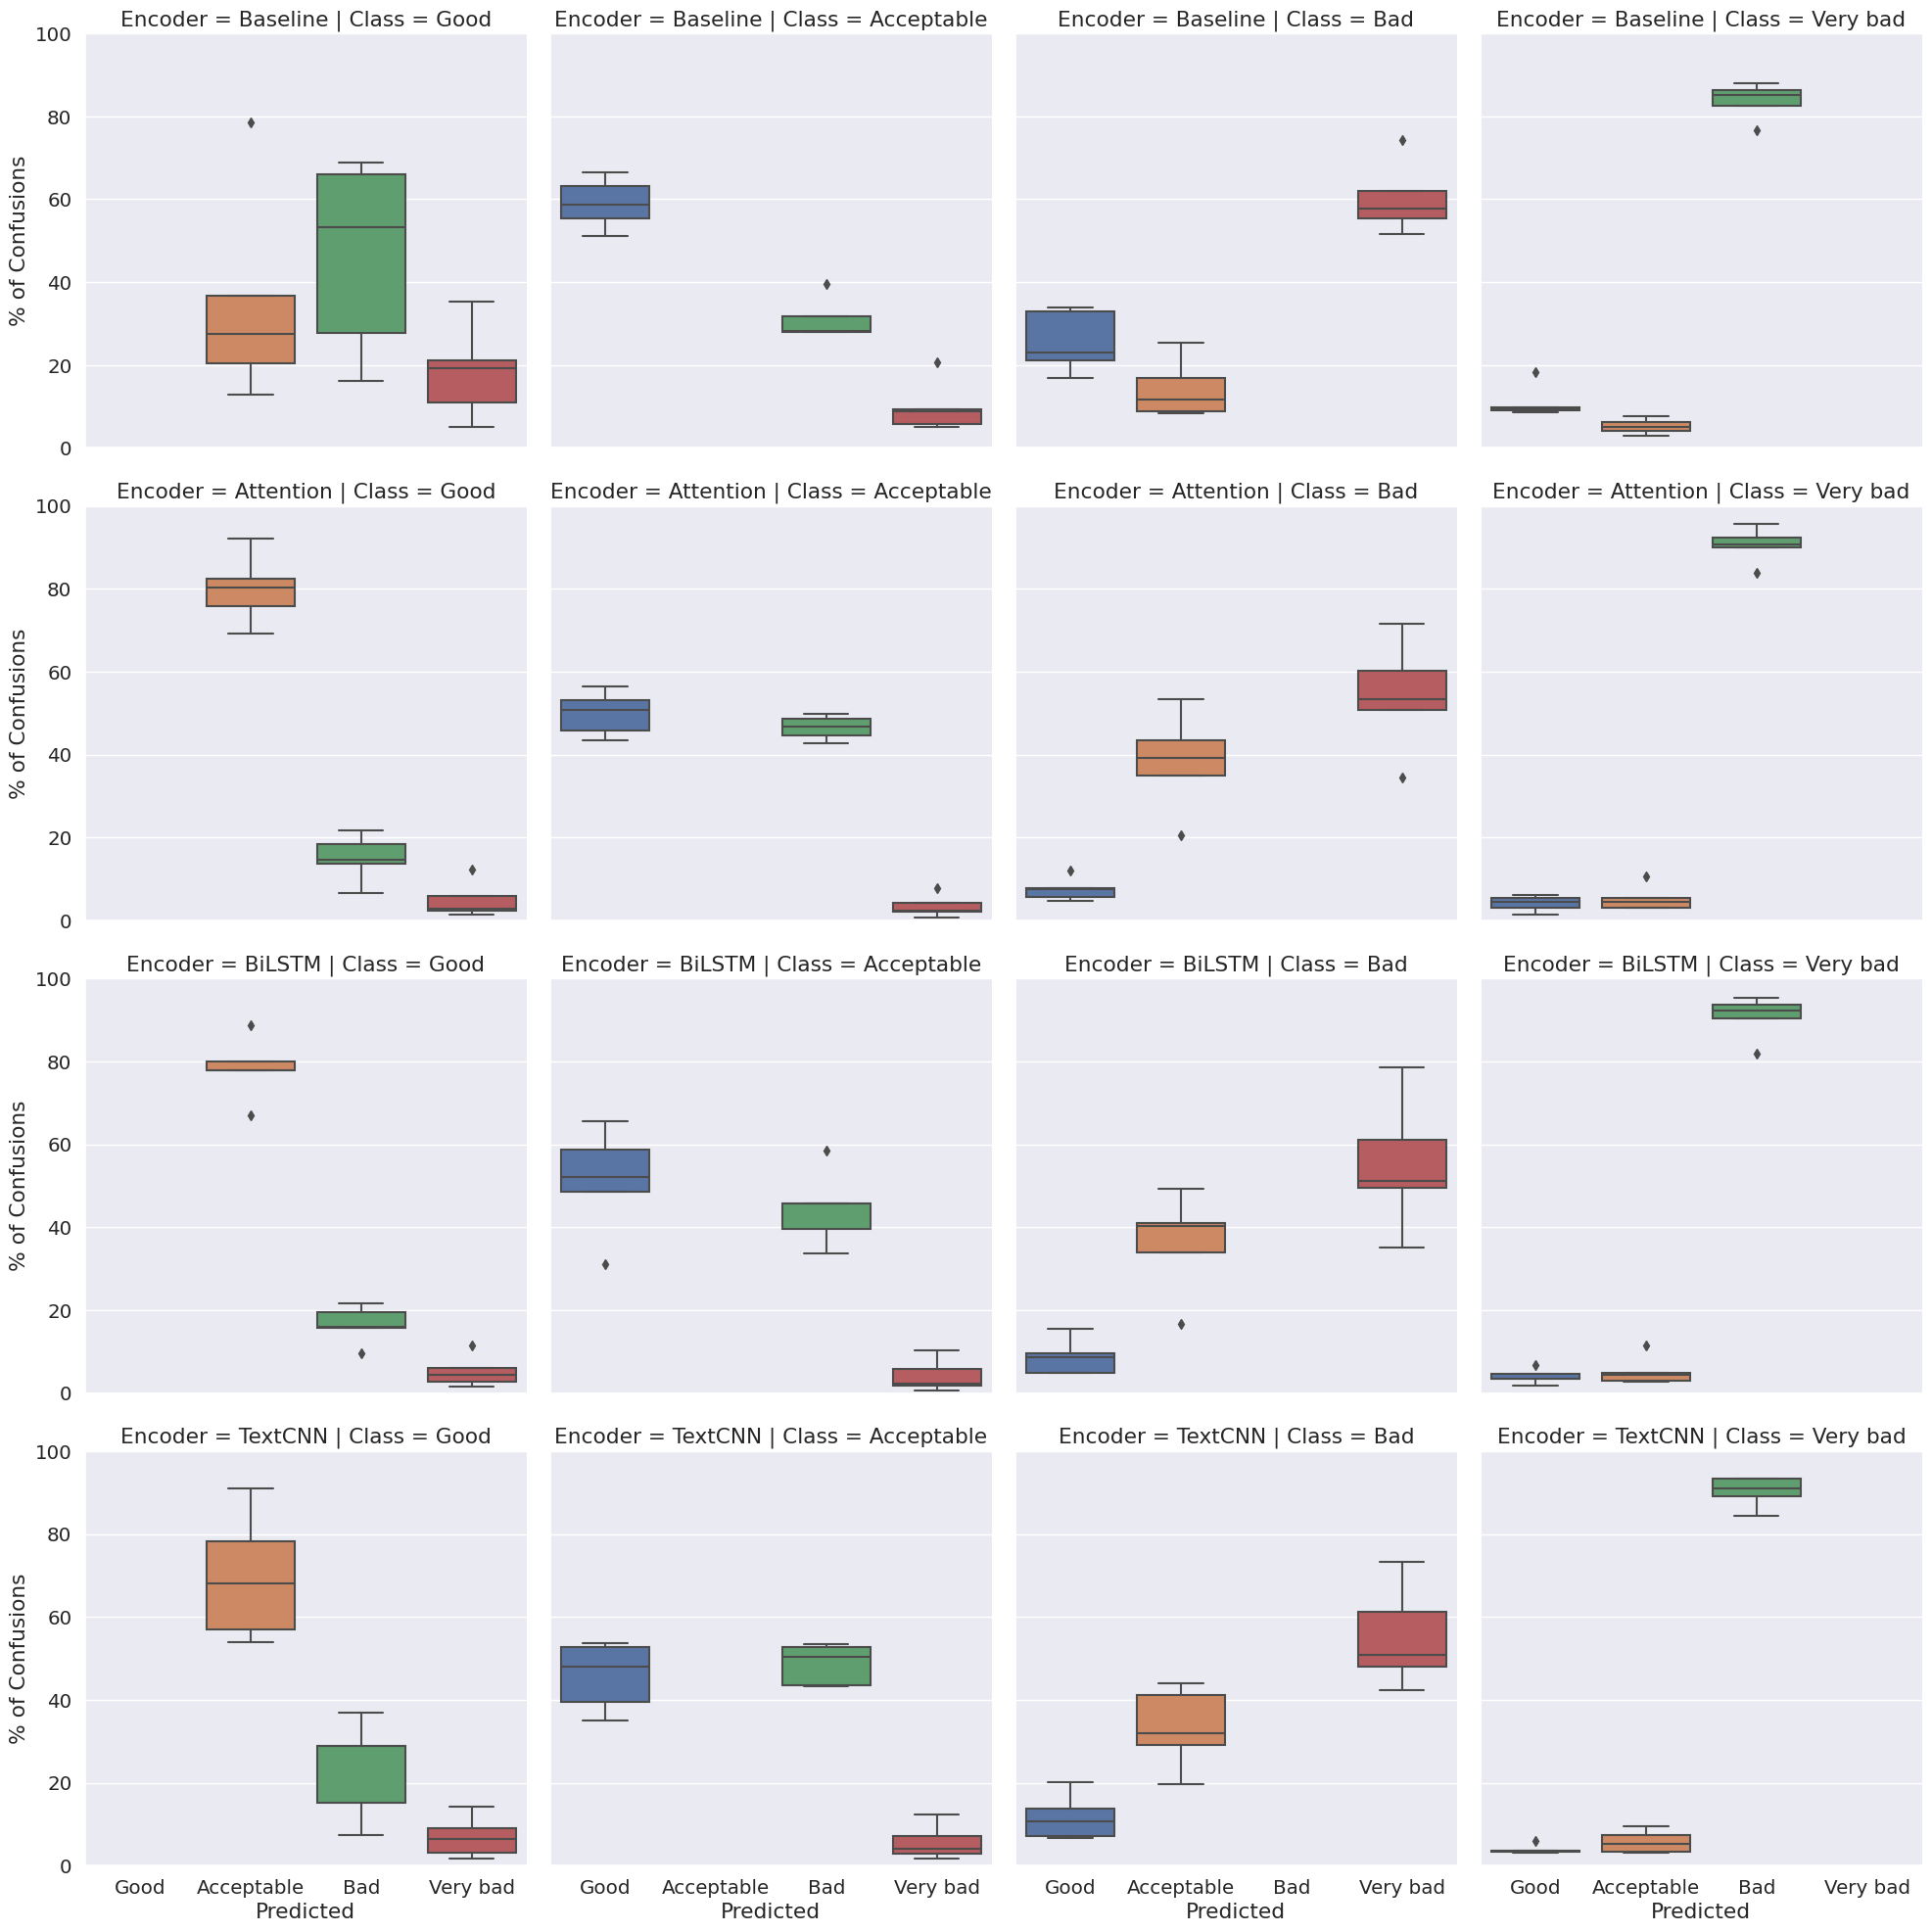

In [179]:
sns.set(font_scale=1.3)
g = sns.catplot(
    data=new_df.sort_values(
        by="Predicted", 
        key=lambda col: col.apply(lambda row: ["Good", "Acceptable", "Bad", "Very bad"].index(row))
    ), 
    kind="box",
    #x="Length (NFD Character Count)", 
    y="% of Confusions", 
    row="Encoder", 
    #size="Support",
    col="Class", 
    x="Predicted",
    hue_order=["Good", "Acceptable", "Bad", "Very bad"],
    col_order=["Good", "Acceptable", "Bad", "Very bad"],
    row_order=["Baseline", "Attention", "BiLSTM", "TextCNN"],
    facet_kws=dict(ylim=(0, 100)),
    #palette=sns.color_palette("Set3", 10)
)

plt.savefig('confusions.jpg', dpi=400)